In [1]:
!pip install pennylane
!pip install qiskit==0.45.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 65.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 36.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 35.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 5.5 MB/s eta 0:00:00


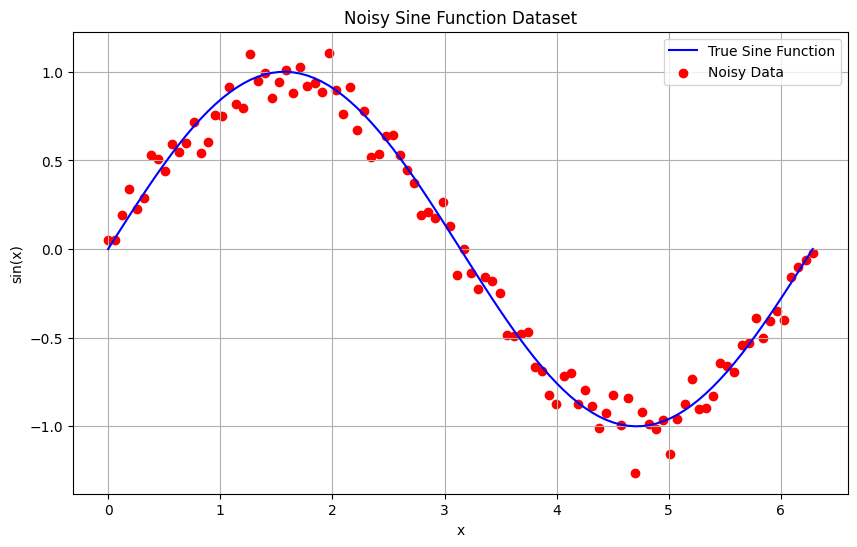

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Generate noisy sine wave data
np.random.seed(42)
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x) + 0.1 * np.random.normal(size=x.shape)  # Noisy sine wave

# Step 3: Plot the noisy sine function
plt.figure(figsize=(10, 6))
plt.plot(x, np.sin(x), label='True Sine Function', color='blue')
plt.scatter(x, y, label='Noisy Data', color='red')
plt.title('Noisy Sine Function Dataset')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.grid(True)
plt.show()
# Convert to PyTorch tensors
x_train = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Goal: See how QML can be used to fit the <span style="color:blue">Blue Original sine curve<span/> 

In [16]:
import pennylane as qml

n_qubits = 1

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    #qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (1, n_qubits)}

# Quantum layer definition using PennyLane's `qnn` module
qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)


In [17]:
import torch.nn as nn
import torch.optim as optim

class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.fc1 = nn.Linear(1, n_qubits)
        self.qlayer = qlayer
        self.fc2 = nn.Linear(n_qubits, 1)

    def forward(self, x):
        x = torch.sin(self.fc1(x))
        x = self.qlayer(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = HybridModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.3)


In [18]:
# Training loop
epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Plot the results
model.eval()
with torch.no_grad():
    y_pred = model(x_train)


Epoch 20/300, Loss: 0.4328327178955078
Epoch 40/300, Loss: 0.18880344927310944
Epoch 60/300, Loss: 0.053192269057035446
Epoch 80/300, Loss: 0.01766485720872879
Epoch 100/300, Loss: 0.013423390686511993
Epoch 120/300, Loss: 0.00895658228546381
Epoch 140/300, Loss: 0.008251608349382877
Epoch 160/300, Loss: 0.008208464831113815
Epoch 180/300, Loss: 0.008189518004655838
Epoch 200/300, Loss: 0.00818594079464674
Epoch 220/300, Loss: 0.008186000399291515
Epoch 240/300, Loss: 0.031061625108122826
Epoch 260/300, Loss: 0.011319989338517189
Epoch 280/300, Loss: 0.008809791877865791
Epoch 300/300, Loss: 0.008407067507505417


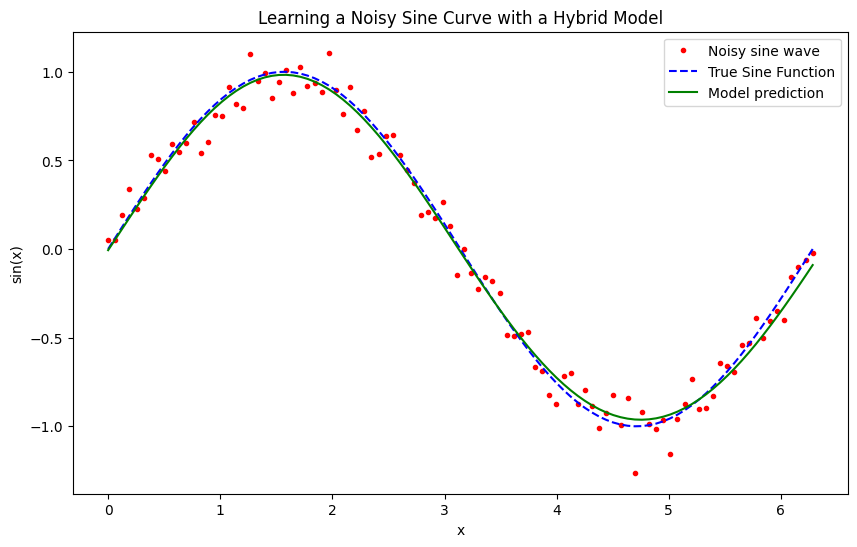

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'r.', label='Noisy sine wave')
plt.plot(x, np.sin(x), label='True Sine Function', color='blue', ls="--")
plt.plot(x, y_pred.numpy(), 'g-', label='Model prediction')
plt.title('Learning a Noisy Sine Curve with a Hybrid Model')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.show()